created 7-18-24

#  <mark style="background-color: #D6F74C"> <font color ='8C9EFF'> Temperature Stratification \& Barotropic Streamfunctions </font></mark>

#  <mark style="background-color: #F06038"> <font color ='D6F74C'> Table of Contents </font></mark>
1. **[Background](#1)**
2. **[Stratification](#2)** \
    a. [Calculate mean](#2a) \
    b. [Calculate difference](#2b)
3. **[Barotropic Streamfunction](#3)**
4. **[Baroclinic Streamfunction](#4)**\
    a. [KD=5E-6](#4a)\
    b. [KD=1E-5](#4b)\
    c. [KD=0](#4c)

# <mark style="background-color: #FCD9BE"> <font color ='F06038'> 1. Background </font></mark>

## <font color ='F06038'> Simulations. </font>
This notebook contains temperature stratification and barotropic (and baroclinic) streamfunctions for ocean simulations under different conditions where KD is the background diapycnal diffusivity measured in $m^2 /s$. 

|FILE NAME | CHANGES |
| :---     | :---    |
|`zeroKD`    | KD = $0$|
|`SB`        | KD = $5 \times 10^{-6}$|
|`medKD`     | KD = $1 \times 10^{-5}$|

## <font color ='F06038'> Stratification. </font>
Temperature is used as a proxy for density stratification because salinity is held constant for the entire basin (35 psu) for all time.

## <font color ='F06038'> Barotropic Streamfunction. </font>
$ \psi = \int_{x_W}^{x_E} \int_{z}^0 v \,dz \,dx$

>- Integrates through entire ocean depth (as opposed to only integrating v in the x-direction for a baroclinic streamfunction)

Code is also written for baroclinic streamfunction at 5 different depths. It is commented out at end of notebook.

In [1]:
import xarray as xr
from xgcm import Grid
import numpy as np
import warnings
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import cmocean.cm as cmo
import cmocean
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize']=(8,5)

In [2]:
ocean_geo = xr.open_dataset('/h/kuyeda/3-12_sb/sb_ocean_geometry.nc')
ocean_geo = ocean_geo.rename({'lath' : 'yh', 
                'lonh' : 'xh',
                'latq' : 'yq',
                'lonq' : 'xq'})
# ocean_geo

# <mark style="background-color: #8C9EFF"> <font color ='FCDBE'> 2. Stratification- zonally averaged temperature </font></mark>
<a name=2></a>

## <font color ='8C9EFF'> 2a. Calculate mean over time and longitude. </font>
<a name=2a></a>

In [3]:
sb = xr.open_dataset('/h/kuyeda/3-12_sb/7-17_SB_linear_d2_prog__1410_014.nc')
sst = sb.temp.mean(dim='Time')
zonal_mean_temp = sst.mean(dim='xh',skipna=True)

In [4]:
medKD = xr.open_dataset('/h/kuyeda/3-7_KD1E-5/7-20_KD1E-5_linear_d2_prog__1410_014.nc')
medKD_sst = medKD.temp.mean(dim='Time')
zonal_mean_temp_medKD = medKD_sst.mean(dim='xh',skipna=True)

In [5]:
zeroKD = xr.open_dataset('/h/kuyeda/7-8_KD0/7-20_KD0_linear_d2_prog__1410_014.nc')
zeroKD_sst = zeroKD.temp.mean(dim='Time')
zonal_mean_temp_zeroKD = zeroKD_sst.mean(dim='xh',skipna=True)

Text(0.5, 0.98, 'Zonally Averaged Temperature')

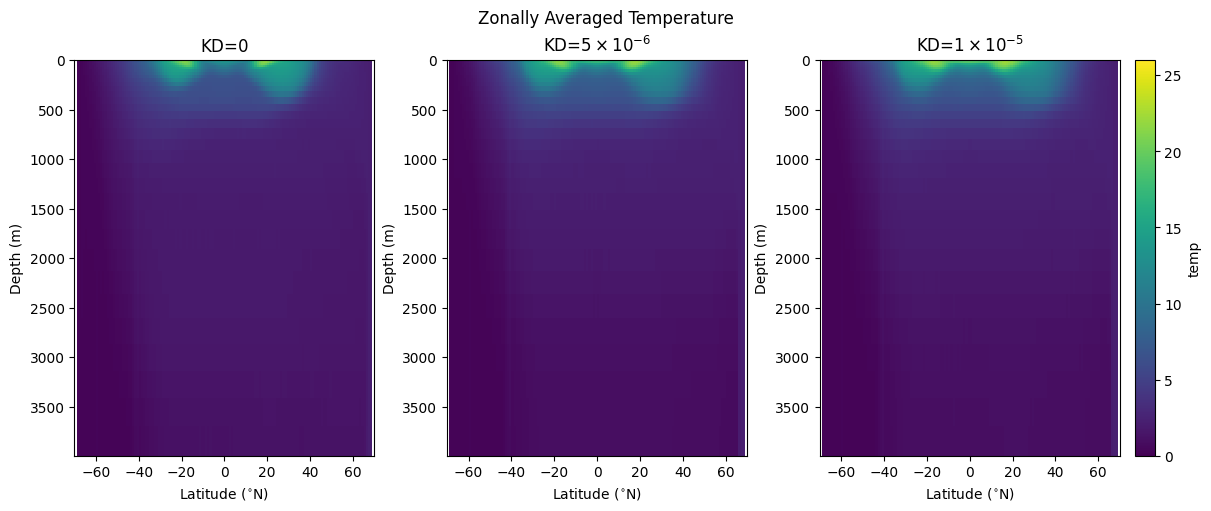

In [31]:
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=(12,5))


zonal_mean_temp_zeroKD.plot(vmin=0,vmax=26,ax=ax[0],add_colorbar=False)
zonal_mean_temp.plot(vmin=0,vmax=26,add_colorbar=False,ax=ax[1])
zonal_mean_temp_medKD.plot(vmin=0,vmax=26,ax=ax[2],add_colorbar=True)

ax[0].set_title('KD=$0$')
ax[1].set_title('KD=$5 \\times 10^{-6}$')
ax[2].set_title('KD=$1 \\times 10^{-5}$')


for i in range(0,3):
    ax[i].invert_yaxis()
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_xlabel('Latitude ($^{\circ}$N)')
fig.suptitle('Zonally Averaged Temperature')

## <font color ='8C9EFF'> 2b. Calculate difference between means. </font>
<a name=2b></a>

In [7]:
# differences
medminussmall = zonal_mean_temp_medKD - zonal_mean_temp 
medminuszero = zonal_mean_temp_medKD - zonal_mean_temp_zeroKD
smallminuszero = zonal_mean_temp - zonal_mean_temp_zeroKD 

Text(0.5, 0.98, 'Difference in Zonally Averaged Temperature')

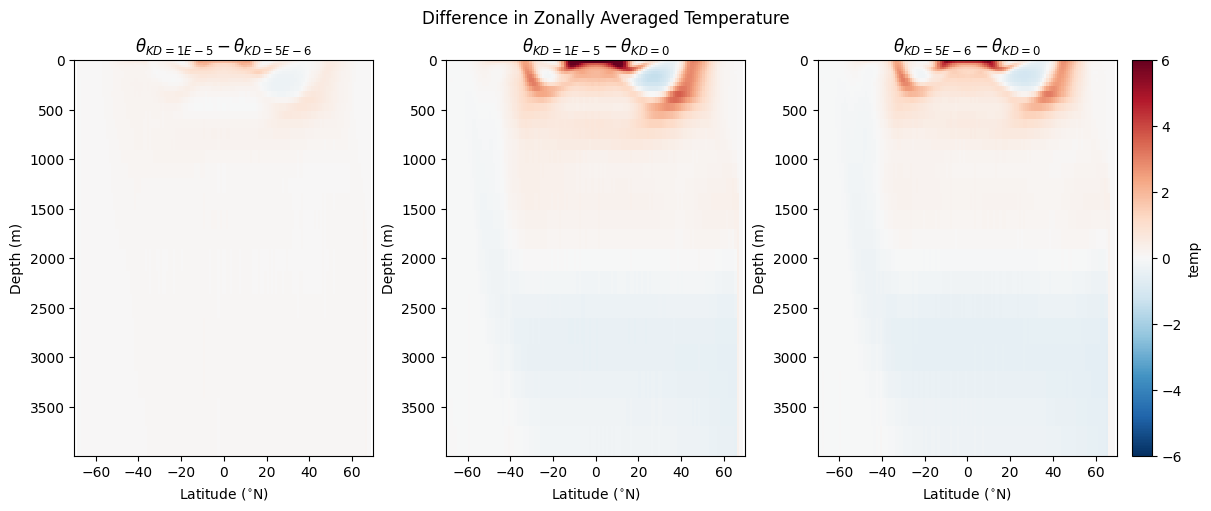

In [17]:
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True,figsize=(12,5))
medminussmall.plot(vmin=-6,vmax=6, add_colorbar=False,ax=ax[0],cmap='RdBu_r')
medminuszero.plot(vmin=-6,vmax=6, ax=ax[1],add_colorbar=False,cmap='RdBu_r')
smallminuszero.plot(vmin=-6,vmax=6, ax=ax[2],cmap='RdBu_r')

ax[0].set_title('$\\theta_{KD=1E-5} - \\theta_{KD=5E-6}$')
ax[1].set_title('$\\theta_{KD=1E-5} - \\theta_{KD=0}$')
ax[2].set_title('$\\theta_{KD=5E-6} - \\theta_{KD=0}$')

for i in range(0,3):
    ax[i].invert_yaxis()
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_xlabel('Latitude ($^{\circ}$N)')
fig.suptitle('Difference in Zonally Averaged Temperature')

#  <mark style="background-color: #D6F74C"> <font color ='8C9EFF'> 3. Barotropic Streamfunction </font></mark>
<a name=3></a>

`v` sits on `zl` coordinates, but calculating $\Delta zl$ = `dz` results in `dz` sitting on `zi` coordinates. So interpolate `v` to also sit on `zi` coordinates.

In [9]:
grid= Grid(sb, coords={'X':{'center':'xh','outer':'xq'},'Y':{'center':'yh','outer':'yq'}, 'Z':{'center':'zl','outer':'zi'}},periodic=['X'])

Text(0.5, 0.98, 'Barotropic Stream Function \n $ \\psi = \\int_{x_W}^{x_E} \\int_{z}^0 v \\,dz \\,dx$')

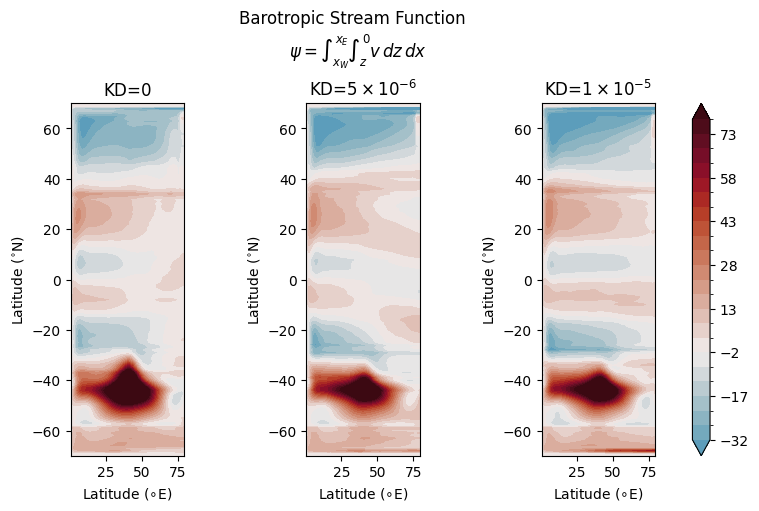

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=3,constrained_layout=True)

newcmap = cmocean.tools.crop(cmocean.cm.balance,-32,80,0)

dss = [zeroKD, sb, medKD]
titles = ['KD=$0$','KD=$5 \\times 10^{-6}$','KD=$1 \\times 10^{-5}$']
clevels=np.arange(-32,80,5)
bt_sf = ['sb_bt', 'medKD_bt', 'zeroKD_bt']
for i in range(0,3):
    dz = grid.diff(dss[i].zi,axis='Z',boundary='fill') 
    # v_interp = grid.interp(dss[i].v.mean(dim='Time'),axis='Z',boundary='fill')
    bt_sf[i] = (dss[i].v.mean(dim='Time') * dz * ocean_geo.dxCv * 10**-6).sum('zl').cumsum('xh')
    m=bt_sf[i].plot.contourf(ax=ax[i],levels=clevels,cmap=newcmap,add_colorbar=False)
    ax[i].set_aspect(140/80)
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('Latitude ($^{\circ}$N)')
    ax[i].set_xlabel('Latitude (${\circ}$E)')
    
fig.colorbar(m,ax=ax)
fig.suptitle('Barotropic Stream Function \n $ \psi = \int_{x_W}^{x_E} \int_{z}^0 v \,dz \,dx$')

#  <mark style="background-color: #F06038"> <font color ='D6F74C'> 4. Baroclinic Streamfunction </font></mark>
<a name=4></a>

## <font color ='F06038'> 4a. KD=$5\times 10^{-6}$ </font>
<a name=4a></a>

In [11]:
'''
fig,ax = plt.subplots(nrows=1,ncols=5,constrained_layout=True,figsize=(12,5))
clevels= np.arange(-150000,150000,10000)
actual_depth=[]
depths = [0,100,200,400,1000]
for i in range(0,5):
    bs_sb = ((sb.v.mean(dim='Time').sel(zl=depths[i],method='nearest')) * ocean_geo.dxCv).cumsum('xh')
    actual_depth.append(int(bs_sb.zl))
    m =bs_sb.plot.contourf(ax=ax[i],levels=clevels,add_colorbar=False)
    

# for i in range(1,5):
#     ax[i].tick_params(axis='y',left=False,labelleft=False)

for i in range(0,5):
    ax[i].set_xlabel('Longitude ($^{\circ}$E)')
    ax[i].set_ylabel('')
    ax[i].set_title(str(actual_depth[i]) + 'm')

ax[0].set_ylabel('Latitude ($^{\circ}$N)')
cbar = fig.colorbar(m,ax=ax[-1])
cbar.set_label('$m^2 /s$')
fig.suptitle('Baroclinic Streamfunction \n KD= $5 \\times 10^{-6}$')
'''

"\nfig,ax = plt.subplots(nrows=1,ncols=5,constrained_layout=True,figsize=(12,5))\nclevels= np.arange(-150000,150000,10000)\nactual_depth=[]\ndepths = [0,100,200,400,1000]\nfor i in range(0,5):\n    bs_sb = ((sb.v.mean(dim='Time').sel(zl=depths[i],method='nearest')) * ocean_geo.dxCv).cumsum('xh')\n    actual_depth.append(int(bs_sb.zl))\n    m =bs_sb.plot.contourf(ax=ax[i],levels=clevels,add_colorbar=False)\n    \n\n# for i in range(1,5):\n#     ax[i].tick_params(axis='y',left=False,labelleft=False)\n\nfor i in range(0,5):\n    ax[i].set_xlabel('Longitude ($^{\\circ}$E)')\n    ax[i].set_ylabel('')\n    ax[i].set_title(str(actual_depth[i]) + 'm')\n\nax[0].set_ylabel('Latitude ($^{\\circ}$N)')\ncbar = fig.colorbar(m,ax=ax[-1])\ncbar.set_label('$m^2 /s$')\nfig.suptitle('Baroclinic Streamfunction \n KD= $5 \\times 10^{-6}$')\n"

## <font color ='F06038'> 4b. KD=$1\times 10^{-5}$ </font>
<a name=4b></a>

In [12]:
'''
fig,ax = plt.subplots(nrows=1,ncols=5,constrained_layout=True,figsize=(12,5))
clevels= np.arange(-150000,150000,10000)
depths = [0,100,200,400,1000]
actual_depth=[]
for i in range(0,5):
    medKD_sb = ((medKD.v.mean(dim='Time').sel(zl=depths[i],method='nearest')) * ocean_geo.dxCv).cumsum('xh')
    actual_depth.append(int(medKD_sb.zl))
    m =medKD_sb.plot.contourf(ax=ax[i],levels=clevels,add_colorbar=False)
    
for i in range(0,5):
    ax[i].set_xlabel('Longitude ($^{\circ}$E)')
    ax[i].set_ylabel('')
    ax[i].set_title(str(actual_depth[i]) + 'm')

ax[0].set_ylabel('Latitude ($^{\circ}$N)')
cbar = fig.colorbar(m,ax=ax[-1])
cbar.set_label('$m^2 /s$')
fig.suptitle('Baroclinic Streamfunction \n KD= $1 \\times 10^{-5}$')
'''

"\nfig,ax = plt.subplots(nrows=1,ncols=5,constrained_layout=True,figsize=(12,5))\nclevels= np.arange(-150000,150000,10000)\ndepths = [0,100,200,400,1000]\nactual_depth=[]\nfor i in range(0,5):\n    medKD_sb = ((medKD.v.mean(dim='Time').sel(zl=depths[i],method='nearest')) * ocean_geo.dxCv).cumsum('xh')\n    actual_depth.append(int(medKD_sb.zl))\n    m =medKD_sb.plot.contourf(ax=ax[i],levels=clevels,add_colorbar=False)\n    \nfor i in range(0,5):\n    ax[i].set_xlabel('Longitude ($^{\\circ}$E)')\n    ax[i].set_ylabel('')\n    ax[i].set_title(str(actual_depth[i]) + 'm')\n\nax[0].set_ylabel('Latitude ($^{\\circ}$N)')\ncbar = fig.colorbar(m,ax=ax[-1])\ncbar.set_label('$m^2 /s$')\nfig.suptitle('Baroclinic Streamfunction \n KD= $1 \\times 10^{-5}$')\n"

## <font color ='F06038'> 4c. KD=0 </font>
<a name=4c></a>

In [13]:
'''
fig,ax = plt.subplots(nrows=1,ncols=5,constrained_layout=True,figsize=(12,5))
clevels= np.arange(-150000,150000,10000)
depths = [0,100,200,400,1000]
actual_depth=[]
for i in range(0,5):
    zeroKD_sb = ((zeroKD.v.mean(dim='Time').sel(zl=depths[i],method='nearest')) * ocean_geo.dxCv).cumsum('xh')
    actual_depth.append(int(zeroKD_sb.zl))
    m =zeroKD_sb.plot.contourf(ax=ax[i],levels=clevels,add_colorbar=False)
    
for i in range(0,5):
    ax[i].set_xlabel('Longitude ($^{\circ}$E)')
    ax[i].set_ylabel('')
    ax[i].set_title(str(actual_depth[i]) + 'm')

ax[0].set_ylabel('Latitude ($^{\circ}$N)')
cbar = fig.colorbar(m,ax=ax[-1])
cbar.set_label('$m^2 /s$')
fig.suptitle('Baroclinic Streamfunction \n KD= $0$')
'''

"\nfig,ax = plt.subplots(nrows=1,ncols=5,constrained_layout=True,figsize=(12,5))\nclevels= np.arange(-150000,150000,10000)\ndepths = [0,100,200,400,1000]\nactual_depth=[]\nfor i in range(0,5):\n    zeroKD_sb = ((zeroKD.v.mean(dim='Time').sel(zl=depths[i],method='nearest')) * ocean_geo.dxCv).cumsum('xh')\n    actual_depth.append(int(zeroKD_sb.zl))\n    m =zeroKD_sb.plot.contourf(ax=ax[i],levels=clevels,add_colorbar=False)\n    \nfor i in range(0,5):\n    ax[i].set_xlabel('Longitude ($^{\\circ}$E)')\n    ax[i].set_ylabel('')\n    ax[i].set_title(str(actual_depth[i]) + 'm')\n\nax[0].set_ylabel('Latitude ($^{\\circ}$N)')\ncbar = fig.colorbar(m,ax=ax[-1])\ncbar.set_label('$m^2 /s$')\nfig.suptitle('Baroclinic Streamfunction \n KD= $0$')\n"